# Assignment 12

In this tutorium, we will work on GANs networks (https://arxiv.org/pdf/1406.2661.pdf). This kind of network is part of the generative networks who are actually able to generate synthetic data. This network is actually composed of two, a generator responsible for generate fake data and a discriminator for investigating on the trueness of the images.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://pathmind.com/images/wiki/GANs.png", width=700)

The disciminator can be see as a very simple fully connected network, composed of several layer of neurons and a simple output of one neurone who just determine if a image is true or false.

The generator looks more like the upscaling part of the segmenetation network. A small piece of noise is injected and the output is an images. 

The training is maybe the most original part. 

First, you train the discriminator alone by injecting the training set (True data so label=True) and a set of data generated by the generator (label=False) you then have a loss to back propagate. *Applause, you trained you discriminator for one batch*

Second, you inject some noise in your generator, the generator produce some fake images, you inject this fake images in you discriminator and use the labels generated by the discriminator to compute your backpropagation. So to train your generator, you will consider the generator and the discriminator as the same network, you just don't train the discriminator in this case.

## 12.1

We ask you then to program you own GANs. this network should be just compose of fully connected layer (no conv). You should define the architecture of the network, then provide two training function one for the generator and one for the discriminator and make him learn!

We will take the MNIST dataset here for simplicity and lightness. The architecture I used was :

G : (Input : random Tensor = 100) => (FC1 : fully connected = 256) => (BatchNormalisation) => (LeakyReLU) => (DropOut) => (FC2 : fully connected = 512) => (BatchNormalisation) => (LeakyReLU) => (DropOut) => (FC2 : fully connected = 784) =>  (Tanh)

D : (Input : flatten images Tensor = 784) => (FC1 : fully connected = 1024) => (BatchNormalisation) => (LeakyReLU) => (DropOut) => (FC2 : fully connected = 512) => (BatchNormalisation) => (LeakyReLU) => (DropOut) => (FC2 : fully connected = 1) =>  (Sigmoid)

This architecture is what I use, it's working but not great, so feel free to change it!!

The training is 20-30min on a 1060 6Go for 100 epochs and batch size of 100. Here, it's a little bit different than before, the loss do not necessarly go done, it's a race between D and G so both cannot be good at the same time.

In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
import torch.optim as optim
from torchvision.utils import save_image
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pylab
import numpy as np

import sys

# If Cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image processing
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

batch_size = 100

# MNIST dataset
train_mnist = torchvision.datasets.MNIST(root='./data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

torch.Size([1, 28, 28])

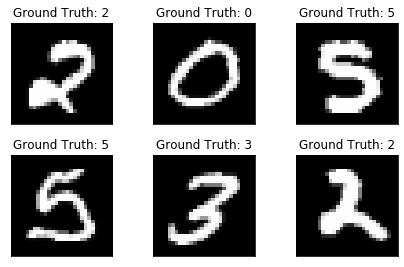

In [3]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

example_data[0].shape

## Create Discriminator  and Generator networks

In [4]:
class FCBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.2)
        )
        
    def forward(self, x):
        return self.block(x)

class Generator(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        
        self.net = nn.Sequential(
            FCBlock(in_size, 256),
            FCBlock(256, 512),
            FCBlock(512, 1024),
            nn.Linear(1024, out_size),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.net(x)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        
        self.net = nn.Sequential(
            FCBlock(in_size, 1024),
            FCBlock(1024, 512),
            nn.Linear(512, out_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

In [6]:
G = Generator(100, 784).cuda()
D = Discriminator(784, 1).cuda()

print(G)
print(D)

Generator(
  (net): Sequential(
    (0): FCBlock(
      (block): Sequential(
        (0): Linear(in_features=100, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
    (1): FCBlock(
      (block): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
    (2): FCBlock(
      (block): Sequential(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
    (3): Linear(in_features=1024, out_features=784,

## Create targets

We need a tensor of 1s to represent true data being given and 0s for false respectively

In [7]:
def true_target(size):
    return Variable(torch.ones(size, 1)).cuda()

def false_target(size):
    return Variable(torch.zeros(size, 1)).cuda()

print(true_target(3))
print(false_target(3))

tensor([[1.],
        [1.],
        [1.]], device='cuda:0')
tensor([[0.],
        [0.],
        [0.]], device='cuda:0')


## Create inputs to generator

We need to create the noise input the generator will use to generate images

In [8]:
def get_noise(size):
    return Variable(torch.randn(size, 100)).cuda()

get_noise(1)

tensor([[ 2.7141e-01,  7.0482e-01,  1.3514e+00,  1.2012e+00,  1.0575e+00,
          1.5327e+00, -3.5600e-01, -6.2838e-02,  1.3896e+00, -1.4275e+00,
          6.4010e-01, -1.4750e-01,  1.4431e+00, -6.5698e-01,  5.9701e-01,
          4.1059e-01,  8.6521e-01,  1.0663e+00, -2.2197e+00,  8.5336e-01,
          1.3377e+00,  1.5391e+00,  1.3257e+00, -1.8500e+00,  1.9280e-04,
         -3.0225e-01, -7.3108e-01, -2.6432e-01, -6.5683e-01,  2.1053e+00,
         -2.4755e-01, -5.6047e-01, -1.6612e+00, -9.3280e-01,  1.5776e-01,
         -2.1202e+00,  6.2790e-01, -1.3059e+00,  1.5832e+00, -1.3957e+00,
          4.6153e-01, -1.8586e-01,  8.9680e-01,  1.5536e-01,  8.8182e-01,
         -1.3840e-01, -1.2493e+00, -9.2498e-01, -5.4926e-01, -2.2194e+00,
          6.5516e-01,  2.5438e-01,  1.2574e+00,  2.3004e+00, -3.2037e-01,
          6.2265e-01, -2.4606e+00, -1.3119e-01, -1.4361e+00,  1.1270e+00,
         -2.6090e-02,  7.9404e-01,  8.5607e-01, -5.1837e-02,  1.6852e-01,
         -8.8395e-01, -1.0145e-02, -1.

## Loss function

After some research, the noise function can be simply implemented by torch's BinaryCrossEntropy loss (https://pytorch.org/docs/stable/nn.html#bceloss)

In [9]:
loss = nn.BCELoss()

## Optimizers

We are using Adam for SGD. 

In [10]:
optimizer_d = optim.Adam(D.parameters(), lr=3e-4)
optimizer_g = optim.Adam(G.parameters(), lr=3e-4)

## Create training methods for generator and discriminator respectively

In [11]:
def train_dis(D, G, data):
    batch_size = len(data)
    
    # generate data, detach to not compute gradient for generator
    generated = G(get_noise(batch_size)).detach()
    
    
    optimizer_d.zero_grad()
    
    # train on data samples
    out_data = D(data)
    l_data = loss(out_data, true_target(batch_size) )
    l_data.backward()

    # train on generated samples
    out_generated = D(generated)
    l_gen = loss(out_generated, false_target(batch_size))
    l_gen.backward()
    
    optimizer_d.step()
    
    acc_data = out_data.sum().item() / batch_size
    acc_gen = 1. - (out_generated.sum().item() / batch_size)
    
    return l_data, l_gen, acc_data, acc_gen

In [12]:
def train_gen(D, G, batch_size):
    optimizer_g.zero_grad()
    
    out = D(G(get_noise(batch_size)))
    l = loss(out, true_target(batch_size))
    l.backward()
    optimizer_g.step()
    
    acc = out.sum().item() / batch_size
    
    return l, acc

## Define the whole training procedure

* kd - how many times successively to train the discriminator
* kg - how many times successively to train the discriminator generator 

In [13]:
def runtrain(D, G, data, epochs=5, kd=5, kg=5):
    for t in range(epochs):
        for i, (x_, y_) in enumerate(data):
            x = x_.cuda().reshape(len(x_), -1)
            ldd, ldg, add, adg = train_dis(D, G, x)
            
            if (i+1) % kd == 0:
                for _ in range(kg):
                    lg, ag = train_gen(D, G, len(x)) 

                sys.stdout.write(f"\rEpoch: {t+1}, Batch: {i+1}, L-Dis-Data: {ldd}, L-Dis-Gen: {ldg}, Acc-Dis-Data: {add}, Acc-Dis-Gen: {adg}, L-Gen: {lg}, A-Gen: {ag}")
                
            

## TRAIN!

In [14]:
runtrain(D, G, train_loader, epochs=100, kd=1, kg=1)
G.eval()

Epoch: 100, Batch: 600, L-Dis-Data: 0.20851798355579376, L-Dis-Gen: 0.23099161684513092, Acc-Dis-Data: 0.8494174194335937, Acc-Dis-Gen: 0.8294478607177734, L-Gen: 1.905755877494812, A-Gen: 0.2500082015991210786

Generator(
  (net): Sequential(
    (0): FCBlock(
      (block): Sequential(
        (0): Linear(in_features=100, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
    (1): FCBlock(
      (block): Sequential(
        (0): Linear(in_features=256, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
    (2): FCBlock(
      (block): Sequential(
        (0): Linear(in_features=512, out_features=1024, bias=True)
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
        (3): Dropout(p=0.2, inplace=False)
      )
    )
    (3): Linear(in_features=1024, out_features=784,

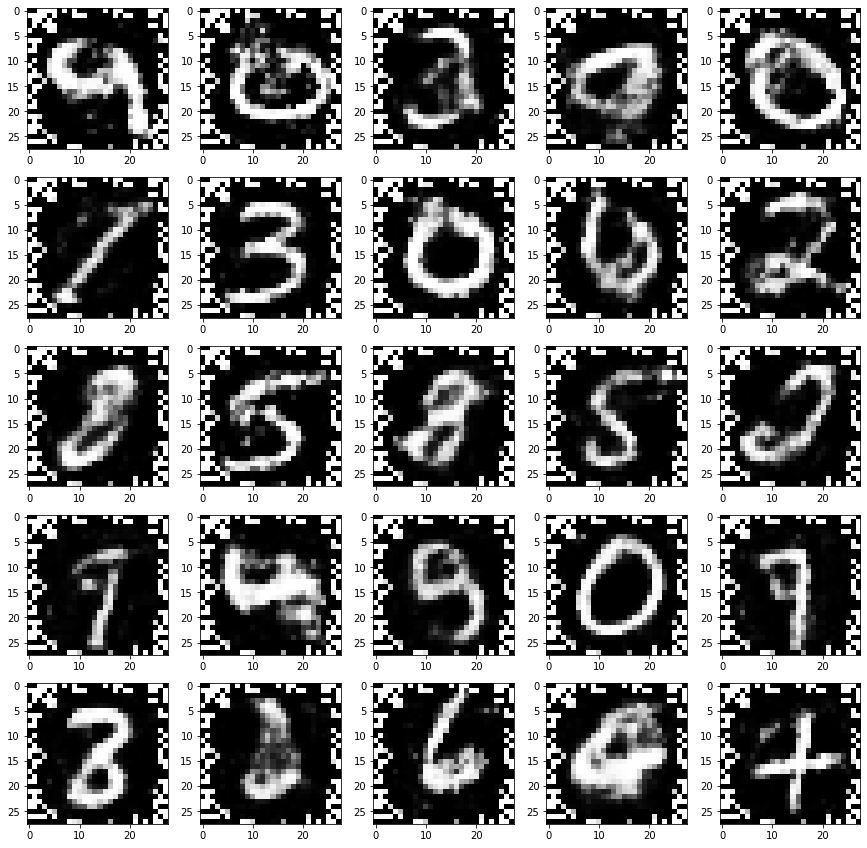

In [15]:
def gen(k=5):
    x = get_noise(k*k)
    out = G(x).reshape(k*k, 28,28).cpu().detach().numpy()
    fig, ax = plt.subplots(k,k, figsize=(15, 15))
    
    for i, axes in enumerate(ax):
        for j, a in enumerate(axes):
            a.imshow(out[i*k + j], cmap='gray', interpolation='none')

gen()

## 8.2 Bonus
For the bonus, fancy stuff we would like you to program a conditional GAN. This GAN should produce the output you want. Instead of feeding your generator with just noise, you feed it with noise and label and it should generated the number you want. 
To do so, you add a label part to your Generator's input and you tell your discriminator what number it should recognize by adding a label part to your Discriminator's input.


In [16]:
Image(url= "https://raw.githubusercontent.com/znxlwm/pytorch-MNIST-CelebA-cGAN-cDCGAN/master/pytorch_cGAN.png", width=900)

In [17]:
#ToDo